In [5]:
from datetime import datetime, timedelta, date
import csv
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

import os
import xgboost as xgb
from sklearn import model_selection, preprocessing
color = sns.color_palette()

In [9]:
def num2log(arr):
    return np.log(arr + 1)

In [61]:
df = pd.read_csv('Full_Monthly.csv',index_col=0)
df.shape

(35064, 81)

In [62]:
df['Date'] = pd.to_datetime(df['Date'])

In [63]:
df.head()

,Date,Ticker,Sector,Industry,Cash From Operations,Current Market Cap,EBITDA Margin,Free Cash Flow,Gross Margin,Interest Expense,...,Yield.10.Yr.Vol.63,Yield.20.Yr.Vol.21,Yield.20.Yr.Vol.63,Yield.30.Yr.Vol.21,Yield.30.Yr.Vol.63,Total,OAS,Shiller.PE.Ratio,VIX.Value,VIX.VXV
1,1998-07-01,BAX,"Consumer, Non-cyclical",Healthcare-Products,146.000,15118.3532,25.5814,17.000,46.0888,39.000,...,0.100107,0.067771,0.117695,0.06957,0.126968,76.83215,72.402903,38.26,24.799999,NaN
2,1998-07-01,VOD,Communications,Telecommunications,NaN,256921.1418,NaN,NaN,NaN,NaN,...,0.100107,0.067771,0.117695,0.06957,0.126968,76.83215,78.340585,38.26,24.799999,NaN
3,1998-07-01,PXD,Energy,Oil&Gas,91.369,2398.8883,45.2357,-56.929,23.5375,41.017,...,0.100107,0.067771,0.117695,0.06957,0.126968,76.83215,147.188061,38.26,24.799999,NaN
4,1998-07-01,KMI,Energy,Pipelines,453.000,36519.0472,27.3650,-10.000,34.1947,297.000,...,0.100107,0.067771,0.117695,0.06957,0.126968,76.83215,113.533557,38.26,24.799999,NaN
5,1998-07-01,AZN,"Consumer, Non-cyclical",Pharmaceuticals,311.000,82119.0000,28.0482,-203.000,69.4947,33.000,...,0.100107,0.067771,0.117695,0.06957,0.126968,76.83215,60.176544,38.26,24.799999,NaN


### Distribution of OAS

In [53]:
df.describe()["OAS"]

count    34999.000000
mean       138.259805
std        103.342547
min      -1503.125000
25%         84.694456
50%        114.509722
75%        159.228902
max       2459.297562
Name: OAS, dtype: float64

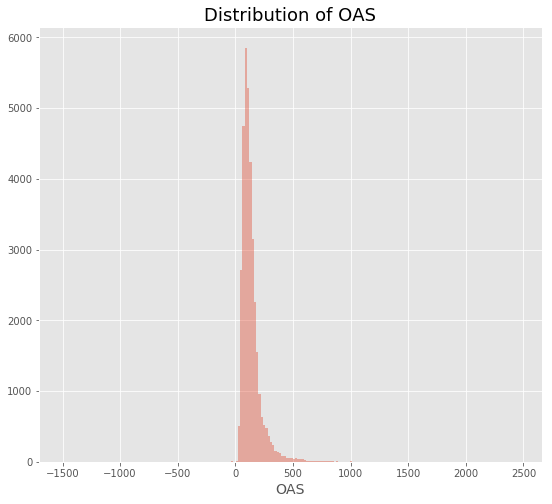

In [50]:
plt.figure(figsize=(9,8))
sns.distplot(df.OAS.dropna(), bins=200, kde=False)
plt.xlabel('OAS', fontsize=14)
plt.title('Distribution of OAS', fontsize = 18)
plt.show()

### Missing Value

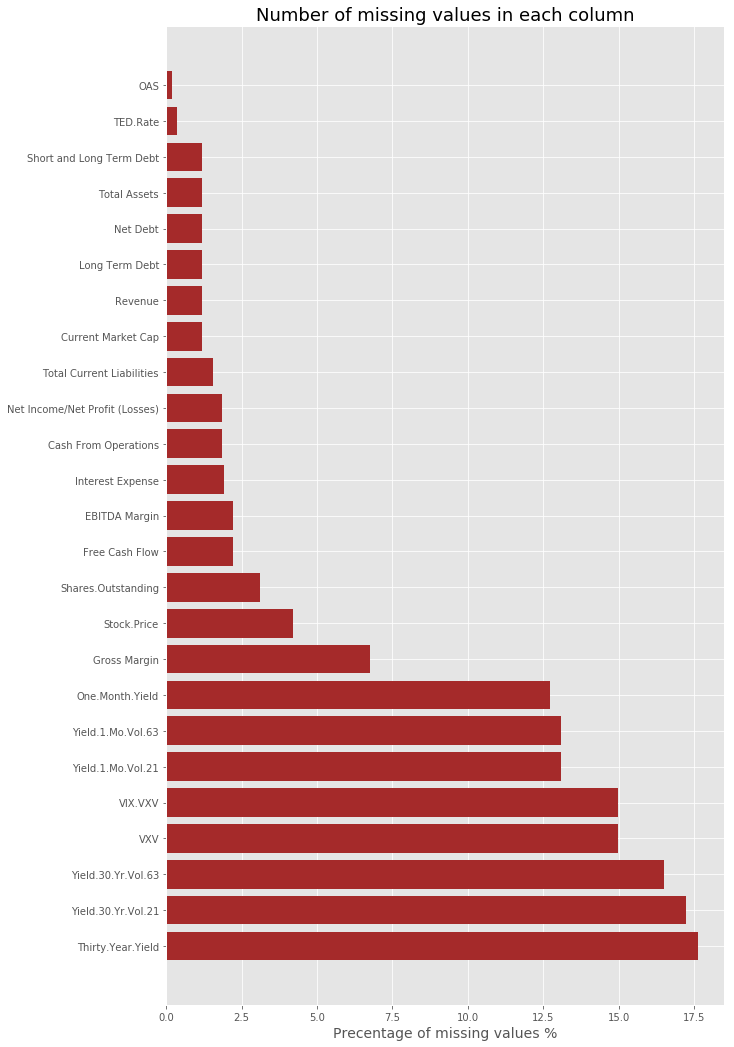

In [49]:
missing = df.isnull().sum(0).reset_index()
missing.columns = ['column', 'count']
missing = missing.sort_values(by = 'count', ascending = False).loc[missing['count'] > 0]
missing['percentage'] = missing['count'] / float(df.shape[0]) * 100
ind = np.arange(missing.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, missing.percentage.values, color='brown')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column.values, rotation='horizontal')
ax.set_xlabel("Precentage of missing values %", fontsize = 14)
ax.set_title("Number of missing values in each column", fontsize = 18)
plt.show()


* We could delete columns with more than 10% missing values?

### Correlation

In [65]:
dfcor = df.drop(["Date","Industry","Ticker","Sector"],1)

In [67]:
for f in dfcor.columns:
    if dfcor[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[f].values)) 
        dfcor[f] = lbl.transform(list(dfcor[f].values))
dtype_df = dfcor.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,float64,77


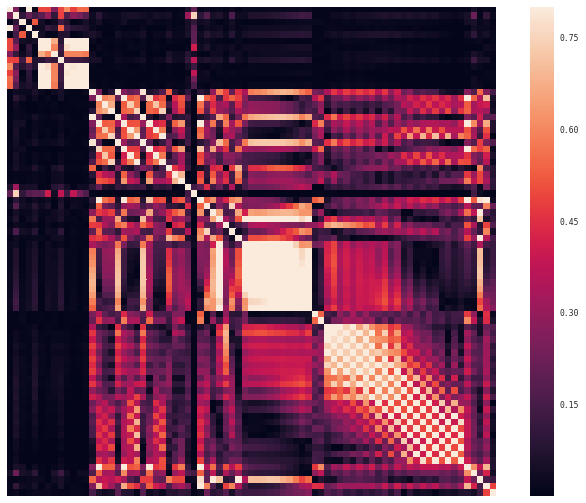

In [68]:
corrmat = dfcor.corr(method='pearson', min_periods=1000)
# plot absolute values
corrmat = np.abs(corrmat)
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, xticklabels = False, yticklabels = False)

* Many of these features are highly correlated.

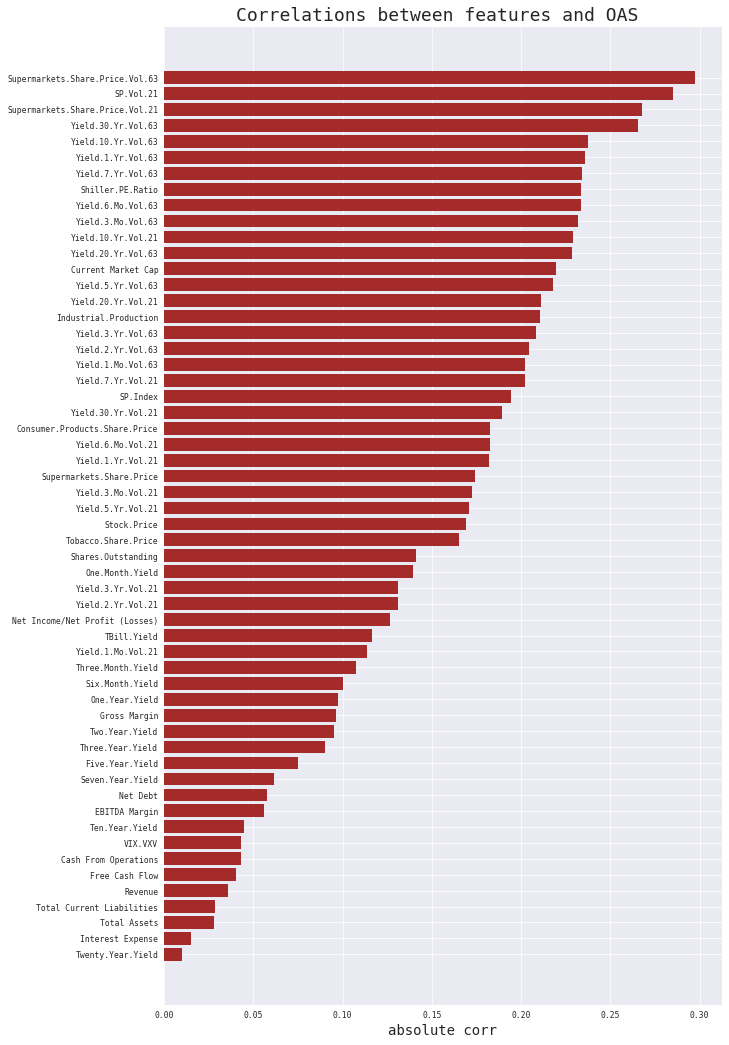

In [94]:
remain_num = 60
corr_target = corrmat['OAS'].reset_index()
corr_target.columns = ['feature','abs_corr']
corr_target = corr_target.sort_values(by = 'abs_corr', ascending = True)[:remain_num].loc[corr_target['abs_corr'] >0.01]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, corr_target.abs_corr.values, color='brown')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 14)
ax.set_title("Correlations between features and OAS ", fontsize = 18)
plt.show()

In [95]:
corr_target_f = list(corr_target.feature.values)

In [96]:
len(corr_target_f)

56

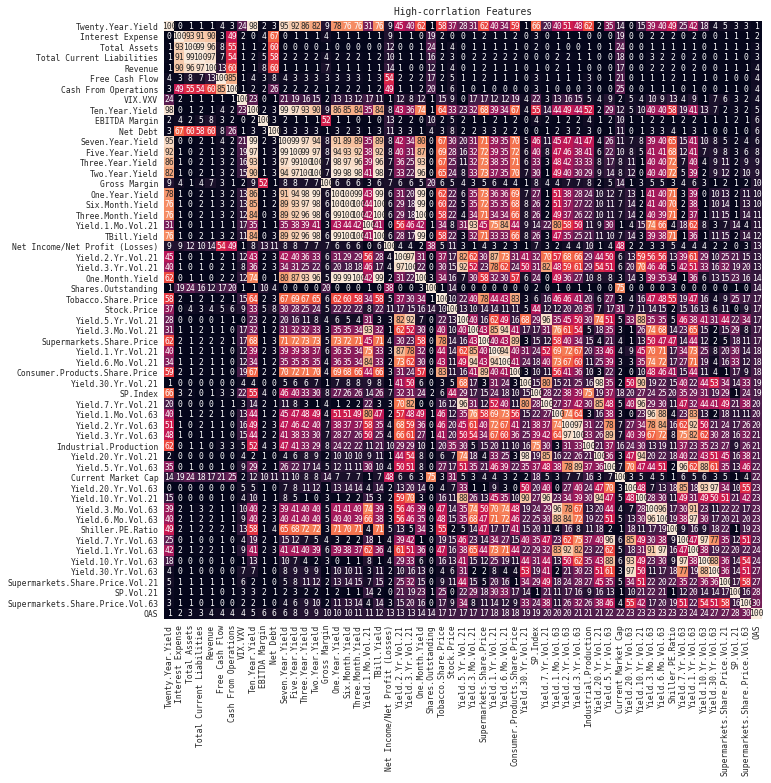

In [97]:
corr_target_f2 = corr_target_f
corr_target_f2.append('OAS')
high_corr = dfcor[corr_target_f2].corr(method='pearson', min_periods=1000)
high_corr = np.abs(high_corr)*100
f, ax = plt.subplots(figsize=(11, 11))
sns.heatmap(high_corr, cbar=False, annot=True, square=True, fmt='.0f', 
            annot_kws={'size': 8})
plt.title('High-corrlation Features')
plt.show()

In [98]:
remove_list = ['Total Assets','Total Current Liabilities', 'Interest Expense','Seven.Year.Yield', 'Five.Year.Yield',
              'Three.Year.Yield','One.Year.Yield','Six.Month.Yield','Three.Month.Yield','Yield.2.Yr.Vol.21',
              'One.Month.Yield','Yield.1.Yr.Vol.21','Yield.2.Yr.Vol.63','Yield.3.Mo.Vol.63']
corr_target_f = [x for x in corr_target_f if x not in remove_list]

### Feature selection by xgb

In [107]:
df =df.dropna()

In [108]:
train_y = df.OAS.values
train_X = df.drop(["Ticker","OAS","Date","Industry","Ticker","Sector"], axis=1)
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
remain_num = 99

[23:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10
[23:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10
[23:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 598 extra nodes, 0 pruned nodes, max_depth=10
[23:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[23:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[23:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=10
[23:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=10
[23:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[23:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 p

[23:37:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 816 extra nodes, 0 pruned nodes, max_depth=10
[23:37:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 918 extra nodes, 0 pruned nodes, max_depth=10
[23:37:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 880 extra nodes, 0 pruned nodes, max_depth=10
[23:37:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 730 extra nodes, 0 pruned nodes, max_depth=10
[23:37:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 938 extra nodes, 0 pruned nodes, max_depth=10
[23:37:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 874 extra nodes, 0 pruned nodes, max_depth=10
[23:37:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 636 extra nodes, 0 pruned nodes, max_depth=10
[23:37:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 886 extra nodes, 0 pruned nodes, max_depth=10
[23:37:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 p

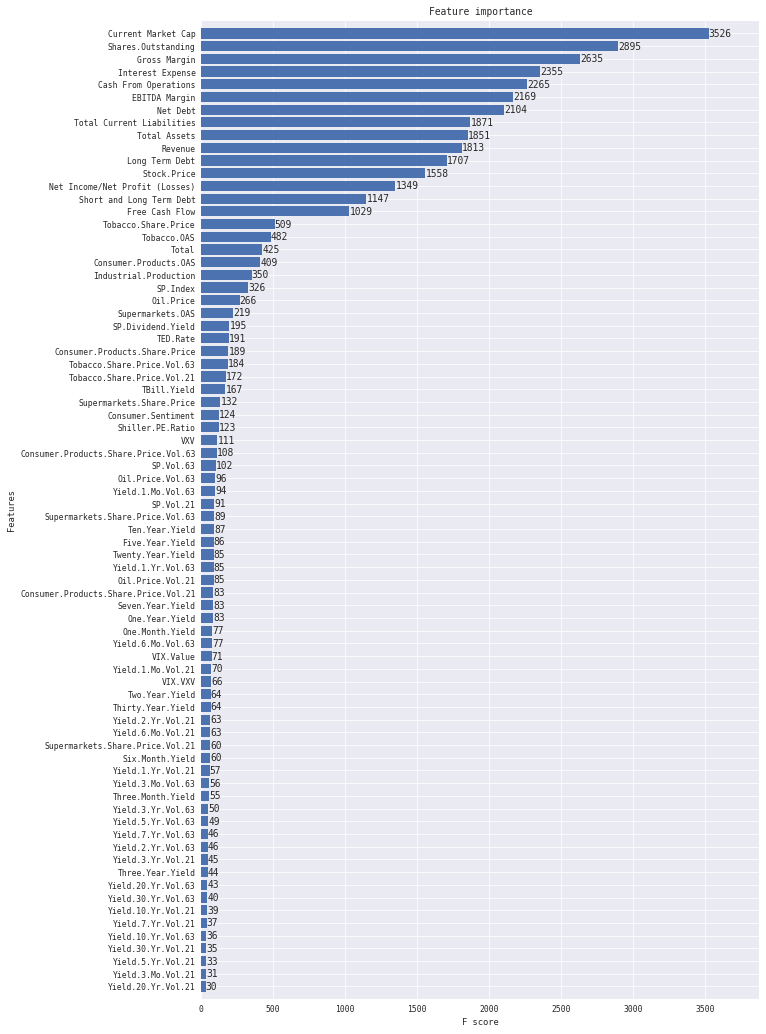

In [109]:
fig, ax = plt.subplots(figsize=(10,18))
xgb.plot_importance(model, max_num_features=remain_num, height=0.8, ax=ax)
plt.show()

In [110]:
importance = model.get_score(importance_type='weight')
tuples = sorted([(k, importance[k]) for k in importance], key=lambda x: x[1], reverse=True)[:remain_num]
xgb_imp_f = [x[0] for x in tuples]

In [111]:
total_f = list(set(xgb_imp_f) | set(corr_target_f))
common_f = list(set(xgb_imp_f) & set(corr_target_f))
xgb_top_f = xgb_imp_f[:10]
corr_top_f = corr_target_f[:10]
print('there are {} features chosen in total'.format(len(total_f)))
print('there are {} features chosen in common'.format(len(common_f)))

there are 77 features chosen in total
there are 42 features chosen in common
